In [1]:
import numpy as np
import random
import sympy as sp
import numpy.linalg as la

import control as pc

%matplotlib notebook
import matplotlib.pyplot as plt
plt.ioff()

import pandas as pd
from sysident import iekf_SISO

plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
# Sampling time
# SET_PARAMETER
iekf_fqz = 125
iekf_T = 1.0/iekf_fqz

# Modellabtastung
T = 1.0/1000
T_max = 40*60 #

# noiselevel
scale = 0.0

In [3]:
''' Define Idetification System model with initial values
System is characterized by number of poles given with numerical values
'''

poles = [-2+3j, -2]
_, (s, s_init), (w, w_init), (p, p_init) = iekf_SISO2.getA_from_list(poles)

iekf = iekf_SISO2.iekf_filter(poles, dT=iekf_T, rho = 0.5)

iekf.initialize_poles(s_init, w_init, p_init)

Starting IEKF with model stucture assumption (System matrix modal form)
A:
⎡s₁   w₁  0 ⎤
⎢           ⎥
⎢-w₁  s₁  0 ⎥
⎢           ⎥
⎣ 0   0   p₁⎦


In [4]:
# first step height u, also mean step height for all steps
u_k0 = np.array([[0.1]])

# first step time
step_time = 0.1

# First values
#x_k = x_k0
#print x_k0, x_k0.shape

u_k = u_k0
#print u_k, u_k.shape

# naive Logging x_k
poles = []
zeros = []
y = []
y_e = []
t_ye = []

u = []
nor0 = []
nor1 = []
nor2 = []
nor3 = []
nor4 = []

step_cnt = 1


In [5]:
import control as con

Af = np.array([[  0.,         -11.06378158],
               [100.,         -74.7335531 ]]
)

Bf = np.array([[-11.11006912],
               [  0.        ]])

Cf = np.array([[ 0., -1.]])

Df = np.array([[ 0.]])

Tf = 0.03306113

pade_order = 3

ss2 = con.ss(Af, Bf, Cf, Df)
#plt.plot(*con.step_response(ss2))
#plt.show()

print con.dcgain(ss2)
print ss2.pole()

# pade approx
numerator, denominator = con.pade(Tf, pade_order)

tf3 = con.series(ss2, con.tf(numerator,denominator))
ss3 = con.tf2ss(tf3)

#plt.plot(*con.step_response(ss3))
#plt.show()

Af = ss3.A
Bf = ss3.B
Cf = ss3.C
Df = ss3.D

print ss3

### Testsystem ####
xx_0 = np.zeros((len(Bf),1))

x_t_real = xx_0
def calc_TestSystem(u):
    global Af, Bf, Cf, Df, x_t_real

    #print "Af:\n", Af
    #print "x_t:\n", x_t_real
    x_dot = Af.dot(x_t_real)
    x_dot = x_dot + Bf.dot(u)
    y = Cf.dot(x_t_real) + Df.dot(u)
    
    #print x_dot
    x_t_real = x_t_real + x_dot*T

    y =  y + np.random.normal(0, scale)
    return y

[[1.0041837]]
[-54.39316289 -20.34039021]
A = [[-9.94759830e-14  7.33817988e-14  6.60095341e-14  4.57602705e-14
   3.67393746e+00]
 [ 1.00000000e+02  5.61019710e-14  4.33963367e-14 -5.47567951e-14
   3.08899128e+01]
 [ 0.00000000e+00 -1.00000000e+02  7.18998157e-14 -1.71533536e-13
  -7.82460267e+01]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+02 -3.14481925e-14
   8.31248282e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e+03
  -4.37697553e+02]]

B = [[ 36.89308114]
 [-60.98634759]
 [-40.32555132]
 [-11.11006912]
 [  0.        ]]

C = [[ 0.   0.   0.   0.  -0.1]]

D = [[0.]]



In [6]:
# return real part of a vector
def real_vector(vector):
    return map(lambda x: x.real, vector)

# return imaginary part of a vector
def imag_vector(vector):
    return map(lambda x: x.imag, vector)

In [7]:
np.random.seed(123) # Set the random number generator for fixed step length t

In [8]:
#%%time
##########################################################
# Loop start
for cnt, t in enumerate(np.arange(T, T_max, T)):

    ####################################################
    # Every time_step a new step is performed
    if np.isclose(t, step_time, T):
        u_k = u_k0 + random.uniform(-1, 1) # random step height
        
        step = np.random.randint(low=0, high=3000)*T
        step_time = step + t # random step length

        print "step @ {} for {}: u={}".format(t, step, u_k)
        
        # >>> Logging of pole trajectories
        s_k = np.array(iekf.s_from_z(*iekf.z_k.ravel())).T
        w_k = np.array(iekf.w_from_z(*iekf.z_k.ravel())).T
        p_k = np.array(iekf.p_from_z(*iekf.z_k.ravel())).T
        poles.append(np.array([complex(si,wi) for si,wi in zip(s_k, w_k)] +
                              [complex(si,-wi) for si,wi in zip(s_k, w_k)] +
                              [pi for pi in p_k]))

        A_k = iekf.AA(*iekf.z_k.ravel())
        B_k = iekf.BB(*iekf.z_k.ravel())
        C_k = iekf.CC(*iekf.z_k.ravel())
        D_k = iekf.DD(*iekf.z_k.ravel())
        zeros.append(pc.zero(pc.ss(A_k, B_k, C_k, D_k)))
        
        
        step_cnt = step_cnt + 1
        #print u_k, type(u_k), u_k.shape
        
    # >>> Logging of u
    u.append(u_k[0,0])
    
    ####################################################
    
    ##### Get system response y
    y_t = calc_TestSystem(u_k)
    #print u_k, u_k.shape
    #print y_t, y_t.shape
    
    # >>> Logging of y
    y.append(y_t[0,0])
    
    # Works only for integer divisions of frequencies!
    if cnt%int(iekf_T/T) == 0:
        t_ye.append(t)
        
        y_k, err = iekf.callback_u(u_k[0,0], y_t[0,0])
        

        # >>> Logging of estimated y (y_e) according to current state z
        y_e.append(y_k[0,0])


        # Naive tracking of performance 
        nor0.append(np.trace(iekf.P_k))
        nor1.append(la.norm(iekf.P_k, 'fro'))
        nor2.append(la.norm(iekf.P_k, np.inf))
        nor3.append(la.norm(iekf.P_k, 1))
        nor4.append(la.norm(iekf.P_k, 2))
    
print "------------------"

step @ 0.1 for 0.481: u=[[-0.66684421]]
step @ 0.581 for 2.41: u=[[-0.88608328]]
step @ 2.989 for 2.402: u=[[0.41299477]]
step @ 5.386 for 0.833: u=[[0.49136471]]
step @ 6.213 for 2.652: u=[[-0.70678174]]
step @ 8.857 for 1.312: u=[[0.8620715]]
step @ 10.159 for 2.792: u=[[0.92121542]]
step @ 12.939 for 0.379: u=[[0.01384875]]
step @ 13.305 for 2.791: u=[[0.57834777]]
step @ 16.08 for 0.624: u=[[-0.47227018]]
step @ 16.688 for 2.228: u=[[0.31438263]]
step @ 18.898 for 0.757: u=[[-0.81877006]]
step @ 19.636 for 0.914: u=[[0.24581148]]
step @ 20.53 for 1.08: u=[[0.20935283]]
step @ 21.589 for 1.682: u=[[-0.09081928]]
step @ 23.248 for 0.187: u=[[-0.47579329]]
step @ 23.412 for 2.252: u=[[0.97790297]]
step @ 25.639 for 1.816: u=[[-0.44655307]]
step @ 27.428 for 1.781: u=[[0.00773511]]
step @ 29.18 for 0.058: u=[[-0.61035928]]
step @ 29.209 for 2.171: u=[[0.92054361]]
step @ 31.349 for 1.739: u=[[-0.45101711]]
step @ 33.055 for 2.244: u=[[-0.4724693]]
step @ 35.264 for 0.806: u=[[-0.421302

step @ 282.414 for 0.121: u=[[0.1593485]]
step @ 282.415 for 2.319: u=[[-0.65595095]]
step @ 284.45 for 1.678: u=[[0.50650525]]
step @ 285.842 for 0.826: u=[[-0.09775257]]
step @ 286.382 for 2.164: u=[[-0.34007722]]
step @ 288.258 for 2.666: u=[[-0.6795302]]
step @ 290.634 for 1.495: u=[[-0.88331314]]
step @ 291.837 for 1.674: u=[[0.32110712]]
step @ 293.218 for 1.871: u=[[1.02820748]]
step @ 294.794 for 1.499: u=[[0.24944003]]
step @ 295.997 for 1.231: u=[[0.81418479]]
step @ 296.931 for 0.333: u=[[0.0571928]]
step @ 296.967 for 1.11: u=[[-0.21317318]]
step @ 297.779 for 0.531: u=[[1.04989034]]
step @ 298.012 for 0.395: u=[[-0.22286396]]
step @ 298.109 for 2.769: u=[[-0.29642138]]
step @ 300.578 for 1.45: u=[[-0.67983079]]
step @ 301.726 for 2.528: u=[[-0.18373678]]
step @ 303.95 for 2.926: u=[[0.34876552]]
step @ 306.57 for 0.697: u=[[0.4510763]]
step @ 306.96 for 1.847: u=[[0.75419202]]
step @ 308.499 for 2.697: u=[[-0.80900144]]
step @ 310.885 for 2.151: u=[[0.90674422]]
step @ 312

step @ 500.591 for 1.761: u=[[0.71521862]]
step @ 501.85 for 1.824: u=[[1.04544053]]
step @ 503.171 for 2.704: u=[[-0.54057388]]
step @ 505.37 for 2.688: u=[[0.08807638]]
step @ 507.55 for 0.994: u=[[0.84608401]]
step @ 508.036 for 2.336: u=[[0.64198943]]
step @ 509.862 for 2.411: u=[[0.18725202]]
step @ 511.761 for 1.785: u=[[-0.09808107]]
step @ 513.033 for 2.413: u=[[0.92109548]]
step @ 514.931 for 0.489: u=[[0.89061728]]
step @ 514.932 for 1.457: u=[[-0.37032409]]
step @ 515.873 for 1.327: u=[[0.45991635]]
step @ 516.683 for 1.035: u=[[0.27581471]]
step @ 517.201 for 2.293: u=[[0.63229634]]
step @ 518.975 for 2.147: u=[[0.71732255]]
step @ 520.601 for 2.086: u=[[1.09131343]]
step @ 522.165 for 0.436: u=[[0.38575598]]
step @ 522.166 for 1.921: u=[[0.7727812]]
step @ 523.563 for 2.921: u=[[-0.22514348]]
step @ 525.958 for 1.053: u=[[0.04857231]]
step @ 526.484 for 2.541: u=[[0.37097749]]
step @ 528.496 for 2.919: u=[[0.1787947]]
step @ 530.884 for 1.728: u=[[-0.61671246]]
step @ 532.

step @ 685.144 for 2.715: u=[[0.33723894]]
step @ 687.172 for 1.634: u=[[0.58410324]]
step @ 688.118 for 0.949: u=[[0.14308152]]
step @ 688.378 for 0.821: u=[[0.61527977]]
step @ 688.51 for 1.816: u=[[0.29917448]]
step @ 689.636 for 0.828: u=[[-0.74289255]]
step @ 689.774 for 0.275: u=[[-0.18378193]]
step @ 689.775 for 2.436: u=[[-0.88774335]]
step @ 691.519 for 2.766: u=[[-0.5402063]]
step @ 693.591 for 1.818: u=[[0.26799784]]
step @ 694.714 for 0.443: u=[[1.04637133]]
step @ 694.715 for 0.102: u=[[1.03990638]]
step @ 694.716 for 2.387: u=[[0.17038384]]
step @ 696.406 for 2.596: u=[[-0.77428865]]
step @ 698.303 for 0.702: u=[[-0.76464705]]
step @ 698.306 for 1.411: u=[[1.08793767]]
step @ 699.018 for 2.866: u=[[-0.87843615]]
step @ 701.183 for 0.057: u=[[0.96193891]]
step @ 701.184 for 1.452: u=[[0.74544107]]
step @ 701.934 for 2.413: u=[[-0.21745209]]
step @ 703.643 for 2.786: u=[[0.22540501]]
step @ 705.723 for 1.317: u=[[0.1200721]]
step @ 706.333 for 1.447: u=[[0.66620739]]
step @

step @ 851.832 for 0.311: u=[[-0.08633226]]
step @ 851.833 for 2.161: u=[[0.32601688]]
step @ 853.141 for 2.743: u=[[-0.47986781]]
step @ 855.029 for 1.944: u=[[-0.67538514]]
step @ 856.117 for 1.46: u=[[-0.89615335]]
step @ 856.72 for 2.899: u=[[0.91880892]]
step @ 858.76 for 2.987: u=[[0.1089616]]
step @ 860.886 for 0.386: u=[[0.76309395]]
step @ 860.887 for 2.36: u=[[0.58925076]]
step @ 862.384 for 2.348: u=[[1.02841085]]
step @ 863.868 for 2.484: u=[[-0.47356189]]
step @ 865.486 for 0.626: u=[[0.92104256]]
step @ 865.487 for 0.827: u=[[0.66892811]]
step @ 865.488 for 0.416: u=[[0.03335246]]
step @ 865.489 for 2.566: u=[[0.96884498]]
step @ 867.187 for 0.246: u=[[-0.14474922]]
step @ 867.188 for 0.009: u=[[0.42688106]]
step @ 867.189 for 0.15: u=[[0.1528955]]
step @ 867.19 for 1.199: u=[[-0.57796558]]
step @ 867.521 for 0.676: u=[[-0.59179067]]
step @ 867.522 for 1.838: u=[[0.41232247]]
step @ 868.491 for 1.566: u=[[-0.52584283]]
step @ 869.187 for 2.062: u=[[0.39292463]]
step @ 870

step @ 999.73 for 1.499: u=[[0.63639338]]
step @ 1000.228 for 1.812: u=[[-0.52646956]]
step @ 1001.038 for 0.962: u=[[0.67127317]]
step @ 1001.039 for 2.768: u=[[0.09685107]]
step @ 1002.804 for 2.553: u=[[-0.40437621]]
step @ 1004.352 for 1.771: u=[[0.35855507]]
step @ 1005.117 for 1.657: u=[[-0.05345033]]
step @ 1005.768 for 0.397: u=[[-0.26766019]]
step @ 1005.769 for 2.631: u=[[0.31650199]]
step @ 1007.392 for 0.505: u=[[0.3629943]]
step @ 1007.393 for 1.143: u=[[0.84760661]]
step @ 1007.528 for 2.435: u=[[-0.7364816]]
step @ 1008.954 for 0.208: u=[[-0.69780056]]
step @ 1008.955 for 2.183: u=[[0.43405536]]
step @ 1010.127 for 1.606: u=[[0.44467636]]
step @ 1010.722 for 2.191: u=[[0.91698443]]
step @ 1011.901 for 2.253: u=[[-0.81222432]]
step @ 1013.14 for 2.664: u=[[0.30102056]]
step @ 1014.789 for 2.883: u=[[0.99551733]]
step @ 1016.655 for 0.126: u=[[0.58871221]]
step @ 1016.656 for 1.738: u=[[-0.07148489]]
step @ 1017.376 for 2.979: u=[[-0.45932087]]
step @ 1019.335 for 2.663: u

step @ 1123.991 for 0.06: u=[[-0.49553863]]
step @ 1123.992 for 2.747: u=[[0.70195323]]
step @ 1125.613 for 1.052: u=[[0.80181547]]
step @ 1125.614 for 2.324: u=[[0.4215751]]
step @ 1126.811 for 0.768: u=[[0.91776667]]
step @ 1126.812 for 1.015: u=[[-0.14930824]]
step @ 1126.813 for 2.922: u=[[0.40266497]]
step @ 1128.606 for 1.285: u=[[1.02816214]]
step @ 1128.762 for 0.432: u=[[1.00698001]]
step @ 1128.763 for 0.649: u=[[0.56298318]]
step @ 1128.764 for 1.919: u=[[0.34302459]]
step @ 1129.553 for 0.048: u=[[0.1954266]]
step @ 1129.554 for 0.437: u=[[0.47525788]]
step @ 1129.555 for 1.342: u=[[0.08137642]]
step @ 1129.767 for 0.021: u=[[1.09907862]]
step @ 1129.768 for 2.794: u=[[0.97642976]]
step @ 1131.43 for 1.26: u=[[-0.18319376]]
step @ 1131.558 for 0.475: u=[[0.64993559]]
step @ 1131.559 for 0.437: u=[[0.45067896]]
step @ 1131.56 for 0.573: u=[[-0.37402166]]
step @ 1131.561 for 0.343: u=[[-0.71276458]]
step @ 1131.562 for 1.837: u=[[-0.08324978]]
step @ 1132.266 for 2.327: u=[[-

step @ 1245.55 for 0.527: u=[[-0.8594499]]
step @ 1245.551 for 0.082: u=[[-0.3317011]]
step @ 1245.552 for 2.627: u=[[0.78340209]]
step @ 1246.931 for 2.334: u=[[-0.13314886]]
step @ 1248.016 for 1.352: u=[[-0.48427722]]
step @ 1248.119 for 0.304: u=[[0.9179867]]
step @ 1248.12 for 1.846: u=[[-0.12260207]]
step @ 1248.717 for 1.742: u=[[0.02418682]]
step @ 1249.209 for 0.361: u=[[0.77674609]]
step @ 1249.21 for 1.992: u=[[-0.06731927]]
step @ 1249.951 for 2.64: u=[[0.11502141]]
step @ 1251.339 for 2.175: u=[[-0.61672151]]
step @ 1252.261 for 2.285: u=[[-0.71038528]]
step @ 1253.292 for 2.306: u=[[1.03289808]]
step @ 1254.343 for 2.886: u=[[-0.0898742]]
step @ 1255.972 for 1.371: u=[[-0.68770162]]
step @ 1256.086 for 0.715: u=[[0.73540367]]
step @ 1256.087 for 2.981: u=[[-0.19336347]]
step @ 1257.809 for 1.67: u=[[0.73254222]]
step @ 1258.22 for 2.084: u=[[0.13072857]]
step @ 1259.044 for 0.091: u=[[-0.80327475]]
step @ 1259.045 for 2.408: u=[[1.0696915]]
step @ 1260.192 for 2.612: u=[[

step @ 1337.457 for 1.785: u=[[0.73118769]]
step @ 1337.903 for 0.938: u=[[0.91229865]]
step @ 1337.904 for 2.838: u=[[0.47650291]]
step @ 1339.402 for 0.093: u=[[0.58402963]]
step @ 1339.403 for 0.657: u=[[0.85288691]]
step @ 1339.404 for 2.993: u=[[-0.23177609]]
step @ 1341.055 for 1.184: u=[[-0.29866925]]
step @ 1341.056 for 0.227: u=[[0.10820248]]
step @ 1341.057 for 1.775: u=[[0.9545424]]
step @ 1341.49 for 2.813: u=[[0.32626803]]
step @ 1342.959 for 0.606: u=[[0.14286856]]
step @ 1342.96 for 0.968: u=[[0.12407776]]
step @ 1342.961 for 2.803: u=[[-0.08132762]]
step @ 1344.419 for 1.301: u=[[0.72905758]]
step @ 1344.42 for 0.514: u=[[-0.32613785]]
step @ 1344.421 for 2.088: u=[[1.00585274]]
step @ 1345.163 for 2.027: u=[[-0.00841447]]
step @ 1345.843 for 1.039: u=[[0.91525694]]
step @ 1345.844 for 0.373: u=[[1.04020675]]
step @ 1345.845 for 0.034: u=[[-0.2935316]]
step @ 1345.846 for 0.502: u=[[-0.29789573]]
step @ 1345.847 for 2.856: u=[[0.8909742]]
step @ 1347.355 for 2.828: u=[[

step @ 1411.091 for 2.475: u=[[1.08688407]]
step @ 1412.153 for 2.835: u=[[-0.10478115]]
step @ 1413.574 for 0.874: u=[[0.0724955]]
step @ 1413.575 for 1.516: u=[[-0.0049873]]
step @ 1413.676 for 0.617: u=[[0.49053251]]
step @ 1413.677 for 2.41: u=[[0.52392418]]
step @ 1414.671 for 2.685: u=[[-0.09097942]]
step @ 1415.939 for 1.58: u=[[0.67747389]]
step @ 1416.102 for 2.207: u=[[-0.4847048]]
step @ 1416.891 for 2.998: u=[[-0.24979784]]
step @ 1418.47 for 0.631: u=[[-0.82723676]]
step @ 1418.471 for 1.748: u=[[0.44369659]]
step @ 1418.799 for 2.799: u=[[0.48215109]]
step @ 1420.177 for 1.342: u=[[0.1634939]]
step @ 1420.178 for 0.71: u=[[0.41350384]]
step @ 1420.179 for 0.021: u=[[0.83674466]]
step @ 1420.18 for 1.542: u=[[-0.69603391]]
step @ 1420.301 for 2.238: u=[[-0.06260465]]
step @ 1421.117 for 2.59: u=[[0.35216346]]
step @ 1422.284 for 2.637: u=[[0.52028292]]
step @ 1423.497 for 0.774: u=[[0.80532603]]
step @ 1423.498 for 0.173: u=[[-0.38023102]]
step @ 1423.499 for 2.658: u=[[0.

step @ 1487.45 for 0.875: u=[[0.2381927]]
step @ 1487.451 for 0.585: u=[[0.18914642]]
step @ 1487.452 for 0.733: u=[[0.92443173]]
step @ 1487.453 for 1.474: u=[[-0.10011207]]
step @ 1487.454 for 0.91: u=[[0.20739087]]
step @ 1487.455 for 2.113: u=[[0.4179462]]
step @ 1488.079 for 1.6: u=[[-0.35669071]]
step @ 1488.19 for 2.397: u=[[-0.51375055]]
step @ 1489.097 for 2.857: u=[[1.00899481]]
step @ 1490.463 for 1.781: u=[[-0.41496153]]
step @ 1490.752 for 0.647: u=[[0.18178851]]
step @ 1490.753 for 2.303: u=[[0.22638861]]
step @ 1491.563 for 2.688: u=[[0.27187913]]
step @ 1492.757 for 2.882: u=[[-0.73365053]]
step @ 1494.144 for 1.935: u=[[1.03458469]]
step @ 1494.583 for 2.566: u=[[0.93446439]]
step @ 1495.652 for 1.66: u=[[0.37302235]]
step @ 1495.815 for 1.218: u=[[1.00203903]]
step @ 1495.816 for 1.107: u=[[0.70406039]]
step @ 1495.817 for 1.166: u=[[0.5465175]]
step @ 1495.818 for 0.717: u=[[-0.0171835]]
step @ 1495.819 for 1.588: u=[[-0.73457588]]
step @ 1495.91 for 1.893: u=[[0.847

step @ 1558.696 for 1.897: u=[[-0.56907408]]
step @ 1559.033 for 1.044: u=[[-0.00031029]]
step @ 1559.034 for 1.352: u=[[0.86540209]]
step @ 1559.035 for 2.159: u=[[-0.1576336]]
step @ 1559.633 for 0.225: u=[[-0.84272739]]
step @ 1559.634 for 0.925: u=[[0.41359228]]
step @ 1559.635 for 0.717: u=[[-0.14024196]]
step @ 1559.636 for 0.751: u=[[0.05357671]]
step @ 1559.637 for 0.904: u=[[-0.24664685]]
step @ 1559.638 for 0.436: u=[[0.13456905]]
step @ 1559.639 for 2.804: u=[[0.78376208]]
step @ 1560.881 for 1.903: u=[[0.92839089]]
step @ 1561.222 for 2.078: u=[[-0.33653067]]
step @ 1561.737 for 0.955: u=[[0.00374195]]
step @ 1561.738 for 1.856: u=[[-0.62469682]]
step @ 1562.031 for 2.742: u=[[-0.22024838]]
step @ 1563.209 for 1.696: u=[[0.58393028]]
step @ 1563.341 for 2.41: u=[[-0.87776155]]
step @ 1564.186 for 1.446: u=[[0.89418961]]
step @ 1564.187 for 0.08: u=[[0.68816315]]
step @ 1564.188 for 1.649: u=[[-0.44500728]]
step @ 1564.272 for 2.282: u=[[0.5072157]]
step @ 1564.988 for 1.309

step @ 1620.93 for 1.233: u=[[-0.82828277]]
step @ 1620.931 for 1.867: u=[[0.52199221]]
step @ 1621.176 for 0.849: u=[[0.70383879]]
step @ 1621.177 for 0.62: u=[[1.0162216]]
step @ 1621.178 for 2.193: u=[[0.85391611]]
step @ 1621.748 for 1.418: u=[[0.7471961]]
step @ 1621.749 for 1.696: u=[[0.68229414]]
step @ 1621.822 for 1.104: u=[[0.33948751]]
step @ 1621.823 for 0.797: u=[[-0.67292952]]
step @ 1621.824 for 0.403: u=[[0.89192346]]
step @ 1621.825 for 0.914: u=[[-0.48417569]]
step @ 1621.826 for 0.19: u=[[0.29066514]]
step @ 1621.827 for 1.518: u=[[-0.31866704]]
step @ 1621.828 for 0.18: u=[[-0.12946367]]
step @ 1621.829 for 0.708: u=[[1.04626173]]
step @ 1621.83 for 0.081: u=[[0.97232175]]
step @ 1621.831 for 2.993: u=[[-0.45512521]]
step @ 1623.2 for 0.019: u=[[-0.42623655]]
step @ 1623.201 for 1.545: u=[[0.05488046]]
step @ 1623.202 for 1.275: u=[[-0.86781095]]
step @ 1623.203 for 2.264: u=[[-0.24754931]]
step @ 1623.842 for 2.056: u=[[-0.84315726]]
step @ 1624.273 for 0.953: u=[[

step @ 1669.169 for 0.533: u=[[-0.2891104]]
step @ 1669.17 for 1.478: u=[[-0.81806628]]
step @ 1669.171 for 2.452: u=[[-0.65270336]]
step @ 1669.952 for 0.165: u=[[-0.73682017]]
step @ 1669.953 for 1.4: u=[[-0.28456684]]
step @ 1669.954 for 0.21: u=[[0.36710767]]
step @ 1669.955 for 0.168: u=[[0.19495219]]
step @ 1669.956 for 0.211: u=[[-0.64590973]]
step @ 1669.957 for 1.092: u=[[0.11804874]]
step @ 1669.958 for 2.207: u=[[0.80629635]]
step @ 1670.493 for 0.401: u=[[-0.06521679]]
step @ 1670.494 for 0.561: u=[[-0.83835919]]
step @ 1670.495 for 2.507: u=[[0.27755651]]
step @ 1671.329 for 2.905: u=[[-0.1330899]]
step @ 1672.56 for 0.167: u=[[0.97516036]]
step @ 1672.561 for 1.254: u=[[-0.32944092]]
step @ 1672.562 for 0.818: u=[[-0.3365959]]
step @ 1672.563 for 1.222: u=[[0.92003851]]
step @ 1672.564 for 1.887: u=[[0.50158418]]
step @ 1672.777 for 1.099: u=[[-0.19334234]]
step @ 1672.778 for 1.891: u=[[0.3946395]]
step @ 1672.995 for 1.248: u=[[0.01001953]]
step @ 1672.996 for 0.466: u=

step @ 1730.781 for 0.417: u=[[0.70509678]]
step @ 1730.782 for 1.676: u=[[-0.41118864]]
step @ 1730.783 for 2.497: u=[[0.96409926]]
step @ 1731.547 for 2.968: u=[[1.08953412]]
step @ 1732.781 for 0.708: u=[[0.04891162]]
step @ 1732.782 for 1.885: u=[[0.99496523]]
step @ 1732.933 for 2.976: u=[[0.6576921]]
step @ 1734.174 for 1.057: u=[[1.05395967]]
step @ 1734.175 for 1.145: u=[[-0.31314417]]
step @ 1734.176 for 1.689: u=[[-0.18661993]]
step @ 1734.177 for 2.465: u=[[-0.47867396]]
step @ 1734.906 for 1.515: u=[[-0.77664954]]
step @ 1734.907 for 0.198: u=[[-0.29877806]]
step @ 1734.908 for 1.367: u=[[0.70988094]]
step @ 1734.909 for 1.77: u=[[0.07946083]]
step @ 1734.943 for 1.996: u=[[0.79475954]]
step @ 1735.203 for 1.141: u=[[0.18627476]]
step @ 1735.204 for 0.636: u=[[-0.50172352]]
step @ 1735.205 for 2.998: u=[[1.08772482]]
step @ 1736.465 for 1.053: u=[[0.85213404]]
step @ 1736.466 for 0.162: u=[[-0.86967117]]
step @ 1736.467 for 2.919: u=[[-0.31743953]]
step @ 1737.647 for 2.924

step @ 1779.466 for 0.331: u=[[0.22082933]]
step @ 1779.467 for 2.07: u=[[0.99711649]]
step @ 1779.756 for 0.743: u=[[-0.81882948]]
step @ 1779.757 for 1.531: u=[[0.27224686]]
step @ 1779.758 for 1.232: u=[[1.03392856]]
step @ 1779.759 for 0.408: u=[[-0.75539416]]
step @ 1779.76 for 1.737: u=[[0.52783057]]
step @ 1779.761 for 0.331: u=[[0.54304191]]
step @ 1779.762 for 0.52: u=[[-0.20124201]]
step @ 1779.763 for 1.248: u=[[-0.39790811]]
step @ 1779.764 for 2.24: u=[[-0.43637445]]
step @ 1780.222 for 0.245: u=[[-0.80447213]]
step @ 1780.223 for 2.273: u=[[-0.44076254]]
step @ 1780.714 for 2.052: u=[[0.89302711]]
step @ 1780.984 for 1.692: u=[[-0.80705478]]
step @ 1780.985 for 2.35: u=[[-0.67961282]]
step @ 1781.552 for 1.496: u=[[-0.68063348]]
step @ 1781.553 for 2.998: u=[[-0.47624022]]
step @ 1782.767 for 0.652: u=[[-0.61478632]]
step @ 1782.768 for 1.283: u=[[0.79020334]]
step @ 1782.769 for 0.59: u=[[-0.04335007]]
step @ 1782.77 for 1.261: u=[[-0.09362062]]
step @ 1782.771 for 1.32:

step @ 1818.64 for 1.771: u=[[0.55237381]]
step @ 1818.641 for 2.732: u=[[0.890774]]
step @ 1819.552 for 2.482: u=[[-0.66407853]]
step @ 1820.212 for 0.499: u=[[0.45748675]]
step @ 1820.213 for 2.668: u=[[-0.06267628]]
step @ 1821.059 for 0.459: u=[[-0.00646278]]
step @ 1821.06 for 2.525: u=[[0.7315931]]
step @ 1821.762 for 1.973: u=[[-0.82715957]]
step @ 1821.912 for 1.467: u=[[0.74912885]]
step @ 1821.913 for 2.87: u=[[1.06784316]]
step @ 1822.959 for 1.931: u=[[-0.09402301]]
step @ 1823.066 for 1.135: u=[[0.31536556]]
step @ 1823.067 for 1.641: u=[[1.05046946]]
step @ 1823.068 for 1.81: u=[[0.95484566]]
step @ 1823.069 for 1.869: u=[[-0.61332296]]
step @ 1823.114 for 2.78: u=[[-0.24511256]]
step @ 1824.069 for 0.77: u=[[-0.24050417]]
step @ 1824.07 for 2.349: u=[[-0.63787404]]
step @ 1824.593 for 2.157: u=[[-0.35495061]]
step @ 1824.924 for 2.964: u=[[-0.46676368]]
step @ 1826.061 for 1.499: u=[[-0.17876037]]
step @ 1826.062 for 1.374: u=[[-0.45636908]]
step @ 1826.063 for 2.57: u=[

step @ 1862.941 for 2.425: u=[[-0.5668172]]
step @ 1863.501 for 0.33: u=[[-0.88027385]]
step @ 1863.502 for 0.01: u=[[0.18886803]]
step @ 1863.503 for 2.569: u=[[0.94082459]]
step @ 1864.206 for 0.401: u=[[-0.44103053]]
step @ 1864.207 for 0.023: u=[[-0.67026273]]
step @ 1864.208 for 1.982: u=[[0.04048947]]
step @ 1864.324 for 0.781: u=[[-0.01295474]]
step @ 1864.325 for 2.998: u=[[0.38454682]]
step @ 1865.456 for 1.584: u=[[0.39398192]]
step @ 1865.457 for 1.755: u=[[1.02605024]]
step @ 1865.458 for 1.403: u=[[-0.6208325]]
step @ 1865.459 for 0.472: u=[[-0.80437076]]
step @ 1865.46 for 2.367: u=[[-0.08648886]]
step @ 1865.96 for 2.107: u=[[0.51667049]]
step @ 1866.199 for 2.949: u=[[0.22532452]]
step @ 1867.279 for 1.924: u=[[0.75331208]]
step @ 1867.334 for 2.843: u=[[0.55165797]]
step @ 1868.307 for 1.532: u=[[-0.14791884]]
step @ 1868.308 for 2.26: u=[[-0.30639255]]
step @ 1868.698 for 0.538: u=[[0.39281437]]
step @ 1868.699 for 2.206: u=[[-0.35266776]]
step @ 1869.035 for 1.986: u

step @ 1906.47 for 0.392: u=[[0.31053154]]
step @ 1906.471 for 1.749: u=[[-0.41040993]]
step @ 1906.472 for 2.064: u=[[0.27393593]]
step @ 1906.628 for 2.892: u=[[-0.76909262]]
step @ 1907.611 for 1.348: u=[[-0.03150062]]
step @ 1907.612 for 0.998: u=[[1.0853258]]
step @ 1907.613 for 2.374: u=[[0.33486378]]
step @ 1908.078 for 0.373: u=[[1.08125256]]
step @ 1908.079 for 2.107: u=[[0.97902625]]
step @ 1908.276 for 2.992: u=[[0.18120865]]
step @ 1909.357 for 0.772: u=[[-0.01488339]]
step @ 1909.358 for 1.665: u=[[-0.55243123]]
step @ 1909.359 for 2.189: u=[[-0.60177954]]
step @ 1909.637 for 1.61: u=[[0.35793255]]
step @ 1909.638 for 0.223: u=[[0.77327934]]
step @ 1909.639 for 2.803: u=[[0.54033971]]
step @ 1910.53 for 1.001: u=[[1.07461257]]
step @ 1910.531 for 0.251: u=[[-0.39255371]]
step @ 1910.532 for 0.051: u=[[-0.40234962]]
step @ 1910.533 for 0.913: u=[[-0.42749979]]
step @ 1910.534 for 1.83: u=[[0.23395172]]
step @ 1910.535 for 1.809: u=[[-0.68086545]]
step @ 1910.536 for 2.719: 

step @ 1951.795 for 2.329: u=[[0.09089692]]
step @ 1952.17 for 0.87: u=[[-0.28814362]]
step @ 1952.171 for 0.405: u=[[0.47630469]]
step @ 1952.172 for 1.162: u=[[0.3425049]]
step @ 1952.173 for 1.376: u=[[0.57728835]]
step @ 1952.174 for 2.416: u=[[0.2578782]]
step @ 1952.636 for 2.912: u=[[-0.45983256]]
step @ 1953.593 for 2.222: u=[[0.57980734]]
step @ 1953.86 for 0.814: u=[[-0.18754103]]
step @ 1953.861 for 0.193: u=[[0.05947681]]
step @ 1953.862 for 2.072: u=[[-0.42643006]]
step @ 1953.979 for 0.401: u=[[-0.41737119]]
step @ 1953.98 for 2.859: u=[[0.63293447]]
step @ 1954.883 for 0.403: u=[[-0.04021861]]
step @ 1954.884 for 1.01: u=[[-0.73388107]]
step @ 1954.885 for 1.716: u=[[0.09398456]]
step @ 1954.886 for 2.195: u=[[0.39411513]]
step @ 1955.124 for 2.048: u=[[-0.42067509]]
step @ 1955.215 for 0.133: u=[[0.44443773]]
step @ 1955.216 for 2.558: u=[[0.87170374]]
step @ 1955.817 for 1.421: u=[[-0.66746221]]
step @ 1955.818 for 2.718: u=[[0.81542855]]
step @ 1956.578 for 1.389: u=[

step @ 1988.417 for 1.312: u=[[0.4149337]]
step @ 1988.418 for 2.435: u=[[0.48884631]]
step @ 1988.863 for 1.276: u=[[0.54261937]]
step @ 1988.864 for 1.996: u=[[0.1216118]]
step @ 1988.87 for 0.101: u=[[-0.39232353]]
step @ 1988.871 for 0.5: u=[[-0.79156303]]
step @ 1988.872 for 0.221: u=[[-0.25791449]]
step @ 1988.873 for 2.922: u=[[0.37128089]]
step @ 1989.804 for 1.52: u=[[0.97593375]]
step @ 1989.805 for 1.696: u=[[-0.43486081]]
step @ 1989.806 for 2.559: u=[[-0.36358435]]
step @ 1990.373 for 0.879: u=[[0.23594658]]
step @ 1990.374 for 0.247: u=[[-0.74044204]]
step @ 1990.375 for 0.114: u=[[0.895517]]
step @ 1990.376 for 2.917: u=[[-0.71606712]]
step @ 1991.3 for 2.146: u=[[-0.00375366]]
step @ 1991.453 for 1.588: u=[[-0.17166283]]
step @ 1991.454 for 0.435: u=[[-0.39803101]]
step @ 1991.455 for 1.388: u=[[0.14181151]]
step @ 1991.456 for 2.329: u=[[-0.19760282]]
step @ 1991.792 for 2.886: u=[[-0.07125272]]
step @ 1992.684 for 2.97: u=[[-0.45137525]]
step @ 1993.659 for 2.042: u=[

step @ 2019.119 for 0.703: u=[[0.01825856]]
step @ 2019.12 for 1.518: u=[[-0.03886214]]
step @ 2019.121 for 0.408: u=[[0.71911766]]
step @ 2019.122 for 1.032: u=[[0.61879857]]
step @ 2019.123 for 2.371: u=[[0.48521375]]
step @ 2019.473 for 1.569: u=[[-0.67640221]]
step @ 2019.474 for 0.877: u=[[0.62211875]]
step @ 2019.475 for 0.09: u=[[0.41069211]]
step @ 2019.476 for 0.798: u=[[-0.41529024]]
step @ 2019.477 for 1.126: u=[[0.16347102]]
step @ 2019.478 for 1.509: u=[[-0.66894269]]
step @ 2019.479 for 1.688: u=[[0.31425062]]
step @ 2019.48 for 0.626: u=[[0.09419924]]
step @ 2019.481 for 1.328: u=[[-0.50554811]]
step @ 2019.482 for 1.586: u=[[0.1451149]]
step @ 2019.483 for 2.772: u=[[-0.13896261]]
step @ 2020.233 for 0.172: u=[[-0.31121106]]
step @ 2020.234 for 0.587: u=[[-0.83647501]]
step @ 2020.235 for 0.784: u=[[0.952687]]
step @ 2020.236 for 1.653: u=[[-0.30880256]]
step @ 2020.237 for 2.769: u=[[0.79525096]]
step @ 2020.983 for 0.25: u=[[-0.03238157]]
step @ 2020.984 for 0.857: u=

step @ 2048.18 for 2.273: u=[[-0.12429498]]
step @ 2048.403 for 1.845: u=[[0.81812051]]
step @ 2048.404 for 0.326: u=[[0.28044585]]
step @ 2048.405 for 0.836: u=[[0.13102084]]
step @ 2048.406 for 0.023: u=[[0.37281874]]
step @ 2048.407 for 1.606: u=[[-0.89223238]]
step @ 2048.408 for 1.901: u=[[-0.87905036]]
step @ 2048.409 for 1.49: u=[[0.48717447]]
step @ 2048.41 for 2.009: u=[[0.58950725]]
step @ 2048.411 for 1.76: u=[[0.63204995]]
step @ 2048.412 for 0.048: u=[[-0.88061591]]
step @ 2048.413 for 1.683: u=[[-0.86490903]]
step @ 2048.414 for 1.523: u=[[-0.12190131]]
step @ 2048.415 for 1.348: u=[[-0.7125668]]
step @ 2048.416 for 0.359: u=[[-0.05777473]]
step @ 2048.417 for 1.043: u=[[-0.84297194]]
step @ 2048.418 for 0.335: u=[[-0.15107599]]
step @ 2048.419 for 0.89: u=[[-0.18989934]]
step @ 2048.42 for 0.148: u=[[1.00523445]]
step @ 2048.421 for 2.605: u=[[0.24287451]]
step @ 2048.975 for 0.698: u=[[0.96221372]]
step @ 2048.976 for 1.896: u=[[-0.8352439]]
step @ 2048.977 for 0.128: u

step @ 2079.537 for 2.436: u=[[-0.21202723]]
step @ 2079.892 for 0.352: u=[[0.93647566]]
step @ 2079.893 for 0.181: u=[[0.6556046]]
step @ 2079.894 for 1.655: u=[[0.03283355]]
step @ 2079.895 for 2.809: u=[[1.09400746]]
step @ 2080.622 for 2.296: u=[[-0.1580913]]
step @ 2080.836 for 1.242: u=[[-0.76854568]]
step @ 2080.837 for 0.842: u=[[1.06852108]]
step @ 2080.838 for 1.161: u=[[0.25604935]]
step @ 2080.839 for 2.226: u=[[1.04190193]]
step @ 2080.982 for 2.667: u=[[-0.44496855]]
step @ 2081.566 for 2.422: u=[[0.99644242]]
step @ 2081.905 for 2.953: u=[[-0.41409582]]
step @ 2082.774 for 2.264: u=[[0.61269345]]
step @ 2082.953 for 0.424: u=[[-0.25810378]]
step @ 2082.954 for 2.542: u=[[-0.24978015]]
step @ 2083.411 for 1.201: u=[[0.86021749]]
step @ 2083.412 for 1.281: u=[[0.90509371]]
step @ 2083.413 for 0.06: u=[[0.36787927]]
step @ 2083.414 for 0.561: u=[[0.99677564]]
step @ 2083.415 for 2.522: u=[[1.0320608]]
step @ 2083.852 for 2.417: u=[[-0.36315187]]
step @ 2084.183 for 2.297: u

step @ 2111.387 for 0.368: u=[[0.80644551]]
step @ 2111.388 for 1.107: u=[[-0.66740751]]
step @ 2111.389 for 2.253: u=[[0.32402285]]
step @ 2111.529 for 1.926: u=[[0.59899695]]
step @ 2111.53 for 0.518: u=[[-0.08118056]]
step @ 2111.531 for 0.844: u=[[0.45689879]]
step @ 2111.532 for 1.439: u=[[0.3065503]]
step @ 2111.533 for 1.154: u=[[0.71350654]]
step @ 2111.534 for 0.997: u=[[-0.49078637]]
step @ 2111.535 for 2.914: u=[[-0.41814257]]
step @ 2112.335 for 1.519: u=[[0.12092052]]
step @ 2112.336 for 2.536: u=[[-0.06918022]]
step @ 2112.758 for 0.222: u=[[-0.05333504]]
step @ 2112.759 for 0.459: u=[[0.24842658]]
step @ 2112.76 for 1.497: u=[[0.7976339]]
step @ 2112.761 for 1.534: u=[[-0.55408703]]
step @ 2112.762 for 0.42: u=[[-0.44785715]]
step @ 2112.763 for 1.942: u=[[0.22464917]]
step @ 2112.764 for 1.173: u=[[0.45560333]]
step @ 2112.765 for 0.64: u=[[0.20732734]]
step @ 2112.766 for 0.738: u=[[-0.38357944]]
step @ 2112.767 for 1.95: u=[[0.67680715]]
step @ 2112.768 for 2.041: u=[

step @ 2135.872 for 0.376: u=[[0.14856768]]
step @ 2135.873 for 2.344: u=[[0.99389755]]
step @ 2136.079 for 1.511: u=[[-0.68206873]]
step @ 2136.08 for 2.905: u=[[0.58810316]]
step @ 2136.847 for 0.523: u=[[-0.2411072]]
step @ 2136.848 for 2.727: u=[[-0.7970241]]
step @ 2137.436 for 0.708: u=[[-0.03108161]]
step @ 2137.437 for 0.586: u=[[-0.10914485]]
step @ 2137.438 for 0.271: u=[[0.25150458]]
step @ 2137.439 for 0.563: u=[[-0.28584683]]
step @ 2137.44 for 1.092: u=[[0.31714178]]
step @ 2137.441 for 1.394: u=[[0.96038796]]
step @ 2137.442 for 0.421: u=[[-0.4685999]]
step @ 2137.443 for 1.597: u=[[0.9458768]]
step @ 2137.444 for 1.98: u=[[-0.87294673]]
step @ 2137.445 for 1.998: u=[[0.90789829]]
step @ 2137.446 for 1.666: u=[[0.41582998]]
step @ 2137.447 for 2.565: u=[[0.09526499]]
step @ 2137.872 for 0.078: u=[[-0.57494828]]
step @ 2137.873 for 0.58: u=[[0.54439229]]
step @ 2137.874 for 1.145: u=[[-0.75158826]]
step @ 2137.875 for 0.953: u=[[0.02221242]]
step @ 2137.876 for 1.837: u=[

step @ 2161.387 for 2.74: u=[[-0.15853874]]
step @ 2161.963 for 1.713: u=[[0.91702077]]
step @ 2161.964 for 2.18: u=[[-0.05751067]]
step @ 2161.98 for 1.04: u=[[-0.89147795]]
step @ 2161.981 for 0.305: u=[[0.97592229]]
step @ 2161.982 for 1.36: u=[[0.07724701]]
step @ 2161.983 for 2.246: u=[[0.67397465]]
step @ 2162.065 for 1.156: u=[[0.05960985]]
step @ 2162.066 for 1.331: u=[[0.20090377]]
step @ 2162.067 for 0.582: u=[[-0.89422564]]
step @ 2162.068 for 0.011: u=[[-0.51138513]]
step @ 2162.069 for 0.86: u=[[0.80627922]]
step @ 2162.07 for 1.436: u=[[0.49651719]]
step @ 2162.071 for 0.507: u=[[-0.58406271]]
step @ 2162.072 for 1.821: u=[[-0.63684668]]
step @ 2162.073 for 2.69: u=[[0.16143539]]
step @ 2162.599 for 2.433: u=[[0.16874195]]
step @ 2162.867 for 2.807: u=[[-0.06842945]]
step @ 2163.509 for 1.925: u=[[0.56687461]]
step @ 2163.51 for 2.502: u=[[-0.28419503]]
step @ 2163.846 for 0.264: u=[[-0.66300512]]
step @ 2163.847 for 0.115: u=[[-0.06584223]]
step @ 2163.848 for 0.969: u=[

step @ 2182.872 for 0.481: u=[[0.48161548]]
step @ 2182.873 for 0.353: u=[[-0.14615025]]
step @ 2182.874 for 2.374: u=[[-0.19537102]]
step @ 2183.063 for 1.088: u=[[-0.19591621]]
step @ 2183.064 for 0.559: u=[[0.68646917]]
step @ 2183.065 for 1.278: u=[[-0.30823527]]
step @ 2183.066 for 2.974: u=[[-0.36790603]]
step @ 2183.854 for 0.556: u=[[0.45929616]]
step @ 2183.855 for 2.167: u=[[-0.6813127]]
step @ 2183.856 for 2.026: u=[[-0.25769551]]
step @ 2183.857 for 0.994: u=[[0.19415197]]
step @ 2183.858 for 2.213: u=[[0.62097581]]
step @ 2183.885 for 2.419: u=[[-0.10571264]]
step @ 2184.118 for 0.655: u=[[0.45481249]]
step @ 2184.119 for 1.675: u=[[0.60567728]]
step @ 2184.12 for 1.103: u=[[0.42391427]]
step @ 2184.121 for 2.602: u=[[1.08326001]]
step @ 2184.537 for 1.263: u=[[0.53558298]]
step @ 2184.538 for 1.8: u=[[-0.89769784]]
step @ 2184.539 for 2.599: u=[[0.85817873]]
step @ 2184.951 for 1.78: u=[[0.47546399]]
step @ 2184.952 for 1.539: u=[[-0.64441116]]
step @ 2184.953 for 2.813: 

step @ 2207.748 for 1.994: u=[[0.31442331]]
step @ 2207.749 for 2.413: u=[[0.4062964]]
step @ 2207.952 for 0.744: u=[[-0.289999]]
step @ 2207.953 for 1.189: u=[[0.96090783]]
step @ 2207.954 for 2.575: u=[[0.34504725]]
step @ 2208.319 for 2.092: u=[[-0.58175208]]
step @ 2208.32 for 0.412: u=[[-0.26095723]]
step @ 2208.321 for 0.43: u=[[1.01008417]]
step @ 2208.322 for 1.867: u=[[0.51033613]]
step @ 2208.323 for 0.688: u=[[-0.68433254]]
step @ 2208.324 for 0.733: u=[[-0.29424205]]
step @ 2208.325 for 0.655: u=[[0.86713396]]
step @ 2208.326 for 0.46: u=[[-0.5222298]]
step @ 2208.327 for 2.933: u=[[-0.23815395]]
step @ 2209.049 for 0.813: u=[[0.24939499]]
step @ 2209.05 for 0.453: u=[[0.38839704]]
step @ 2209.051 for 1.658: u=[[0.48185812]]
step @ 2209.052 for 2.532: u=[[-0.75320495]]
step @ 2209.373 for 1.87: u=[[1.07725867]]
step @ 2209.374 for 1.825: u=[[0.25074999]]
step @ 2209.375 for 2.645: u=[[-0.16784035]]
step @ 2209.808 for 2.604: u=[[0.42326232]]
step @ 2210.2 for 2.091: u=[[0.7

step @ 2227.85 for 2.036: u=[[0.18810968]]
step @ 2227.851 for 1.277: u=[[-0.85153384]]
step @ 2227.852 for 1.656: u=[[1.06100827]]
step @ 2227.853 for 2.699: u=[[-0.74337677]]
step @ 2228.322 for 2.651: u=[[-0.69543409]]
step @ 2228.743 for 0.446: u=[[-0.62754322]]
step @ 2228.744 for 0.317: u=[[0.06273244]]
step @ 2228.745 for 0.328: u=[[0.26920605]]
step @ 2228.746 for 1.691: u=[[-0.60052714]]
step @ 2228.747 for 0.161: u=[[-0.57681478]]
step @ 2228.748 for 1.321: u=[[-0.8648602]]
step @ 2228.749 for 2.951: u=[[-0.37340313]]
step @ 2229.469 for 1.687: u=[[-0.06821845]]
step @ 2229.47 for 1.63: u=[[0.27531793]]
step @ 2229.471 for 1.091: u=[[-0.75600132]]
step @ 2229.472 for 0.932: u=[[1.05783014]]
step @ 2229.473 for 2.762: u=[[0.96308849]]
step @ 2230.003 for 2.522: u=[[-0.4175557]]
step @ 2230.293 for 2.686: u=[[0.10632211]]
step @ 2230.747 for 1.283: u=[[0.81746248]]
step @ 2230.748 for 2.303: u=[[-0.13916695]]
step @ 2230.818 for 0.529: u=[[-0.3904352]]
step @ 2230.819 for 1.937

step @ 2247.54 for 0.744: u=[[-0.20954447]]
step @ 2247.541 for 0.102: u=[[-0.03670674]]
step @ 2247.542 for 2.923: u=[[0.16542847]]
step @ 2248.215 for 2.826: u=[[-0.42888914]]
step @ 2248.79 for 2.105: u=[[-0.13658795]]
step @ 2248.791 for 1.637: u=[[0.09595952]]
step @ 2248.792 for 0.171: u=[[-0.13455435]]
step @ 2248.793 for 0.15: u=[[-0.04519524]]
step @ 2248.794 for 1.824: u=[[-0.8505799]]
step @ 2248.795 for 0.01: u=[[0.03476852]]
step @ 2248.796 for 1.649: u=[[-0.70024785]]
step @ 2248.797 for 1.425: u=[[0.11507396]]
step @ 2248.798 for 0.604: u=[[0.07615477]]
step @ 2248.799 for 1.258: u=[[0.83825991]]
step @ 2248.8 for 2.445: u=[[-0.31314943]]
step @ 2248.994 for 1.236: u=[[0.97461879]]
step @ 2248.995 for 1.658: u=[[-0.78116354]]
step @ 2248.996 for 0.517: u=[[-0.69381884]]
step @ 2248.997 for 0.292: u=[[0.03330566]]
step @ 2248.998 for 0.271: u=[[0.61974736]]
step @ 2248.999 for 1.726: u=[[0.78969438]]
step @ 2249.0 for 0.248: u=[[-0.26053407]]
step @ 2249.001 for 2.267: u=

step @ 2267.151 for 0.176: u=[[0.56394953]]
step @ 2267.152 for 1.204: u=[[0.55727686]]
step @ 2267.153 for 0.077: u=[[-0.77144186]]
step @ 2267.154 for 0.467: u=[[-0.63095964]]
step @ 2267.155 for 0.871: u=[[0.73839747]]
step @ 2267.156 for 2.99: u=[[0.80508832]]
step @ 2267.876 for 1.575: u=[[-0.37193217]]
step @ 2267.877 for 2.502: u=[[0.80146367]]
step @ 2268.109 for 0.354: u=[[0.79602021]]
step @ 2268.11 for 2.878: u=[[0.81644787]]
step @ 2268.718 for 0.856: u=[[0.13450272]]
step @ 2268.719 for 1.412: u=[[-0.23286251]]
step @ 2268.72 for 2.371: u=[[0.11961844]]
step @ 2268.82 for 0.14: u=[[0.51106514]]
step @ 2268.821 for 0.542: u=[[1.07741114]]
step @ 2268.822 for 1.4: u=[[-0.78325625]]
step @ 2268.823 for 2.92: u=[[-0.8010243]]
step @ 2269.472 for 1.418: u=[[0.79481708]]
step @ 2269.473 for 1.773: u=[[-0.32916198]]
step @ 2269.474 for 1.254: u=[[-0.45971391]]
step @ 2269.475 for 2.087: u=[[-0.34783371]]
step @ 2269.476 for 2.173: u=[[-0.32370047]]
step @ 2269.477 for 1.535: u=[[

step @ 2285.733 for 2.178: u=[[-0.43266451]]
step @ 2285.734 for 0.125: u=[[0.23770066]]
step @ 2285.735 for 0.363: u=[[0.15275434]]
step @ 2285.736 for 2.856: u=[[0.25897652]]
step @ 2286.304 for 2.157: u=[[0.98272342]]
step @ 2286.305 for 2.949: u=[[0.79837155]]
step @ 2286.965 for 1.362: u=[[0.72047931]]
step @ 2286.966 for 2.015: u=[[0.69956885]]
step @ 2286.967 for 0.553: u=[[-0.62000525]]
step @ 2286.968 for 1.223: u=[[-0.5965284]]
step @ 2286.969 for 1.752: u=[[0.2094728]]
step @ 2286.97 for 2.019: u=[[0.17474469]]
step @ 2286.971 for 2.858: u=[[0.9149981]]
step @ 2287.54 for 1.33: u=[[0.72845105]]
step @ 2287.541 for 0.784: u=[[0.41253034]]
step @ 2287.542 for 1.205: u=[[0.87815323]]
step @ 2287.543 for 0.607: u=[[1.03558989]]
step @ 2287.544 for 0.898: u=[[-0.48956567]]
step @ 2287.545 for 1.721: u=[[0.08323117]]
step @ 2287.546 for 0.872: u=[[-0.88449427]]
step @ 2287.547 for 1.463: u=[[0.72110717]]
step @ 2287.548 for 1.284: u=[[-0.65011391]]
step @ 2287.549 for 0.07: u=[[-0

step @ 2305.168 for 0.438: u=[[-0.06940025]]
step @ 2305.169 for 2.353: u=[[-0.74647201]]
step @ 2305.215 for 0.439: u=[[0.46275156]]
step @ 2305.216 for 1.857: u=[[-0.20977538]]
step @ 2305.217 for 2.74: u=[[0.48349289]]
step @ 2305.65 for 1.037: u=[[-0.05527874]]
step @ 2305.651 for 0.426: u=[[-0.19180721]]
step @ 2305.652 for 2.926: u=[[-0.60941219]]
step @ 2306.27 for 2.844: u=[[0.75927681]]
step @ 2306.805 for 2.953: u=[[0.85030742]]
step @ 2307.449 for 1.179: u=[[-0.16853438]]
step @ 2307.45 for 0.939: u=[[-0.615016]]
step @ 2307.451 for 0.341: u=[[0.92195484]]
step @ 2307.452 for 2.873: u=[[0.29613742]]
step @ 2308.015 for 1.471: u=[[0.95673938]]
step @ 2308.016 for 2.285: u=[[-0.82111797]]
step @ 2308.017 for 2.513: u=[[0.2333297]]
step @ 2308.22 for 0.036: u=[[0.37687292]]
step @ 2308.221 for 1.635: u=[[0.99265769]]
step @ 2308.222 for 2.363: u=[[0.91194425]]
step @ 2308.275 for 0.175: u=[[-0.35776334]]
step @ 2308.276 for 1.958: u=[[0.34239519]]
step @ 2308.277 for 1.871: u=[

step @ 2321.993 for 1.042: u=[[-0.47590809]]
step @ 2321.994 for 2.442: u=[[0.66112269]]
step @ 2322.112 for 1.033: u=[[0.5141372]]
step @ 2322.113 for 0.358: u=[[-0.64618504]]
step @ 2322.114 for 2.404: u=[[-0.57441186]]
step @ 2322.194 for 1.304: u=[[-0.47275465]]
step @ 2322.195 for 1.289: u=[[-0.5936984]]
step @ 2322.196 for 0.376: u=[[0.07651897]]
step @ 2322.197 for 2.186: u=[[-0.85899453]]
step @ 2322.198 for 0.074: u=[[0.32913091]]
step @ 2322.199 for 0.145: u=[[0.72932434]]
step @ 2322.2 for 1.478: u=[[0.11543527]]
step @ 2322.201 for 0.371: u=[[-0.0948134]]
step @ 2322.202 for 2.353: u=[[-0.50962533]]
step @ 2322.231 for 0.284: u=[[0.9458031]]
step @ 2322.232 for 2.909: u=[[0.02133019]]
step @ 2322.816 for 2.855: u=[[-0.32913852]]
step @ 2323.346 for 2.234: u=[[-0.01499954]]
step @ 2323.347 for 2.22: u=[[0.39353095]]
step @ 2323.348 for 1.417: u=[[0.63191287]]
step @ 2323.349 for 1.16: u=[[-0.1138304]]
step @ 2323.35 for 1.996: u=[[-0.01978335]]
step @ 2323.351 for 0.976: u=[

step @ 2336.922 for 2.379: u=[[0.68722735]]
step @ 2336.962 for 0.359: u=[[-0.7390051]]
step @ 2336.963 for 2.579: u=[[0.03493835]]
step @ 2337.203 for 0.325: u=[[0.90151347]]
step @ 2337.204 for 1.015: u=[[1.05224793]]
step @ 2337.205 for 1.255: u=[[0.42005264]]
step @ 2337.206 for 0.981: u=[[-0.24372518]]
step @ 2337.207 for 0.266: u=[[-0.66377493]]
step @ 2337.208 for 0.779: u=[[0.83867597]]
step @ 2337.209 for 1.509: u=[[0.49314176]]
step @ 2337.21 for 1.988: u=[[1.08749184]]
step @ 2337.211 for 2.334: u=[[-0.5152707]]
step @ 2337.212 for 0.215: u=[[1.01392331]]
step @ 2337.213 for 1.352: u=[[-0.60375541]]
step @ 2337.214 for 2.931: u=[[-0.44584676]]
step @ 2337.805 for 2.65: u=[[-0.28552522]]
step @ 2338.115 for 2.783: u=[[-0.51054223]]
step @ 2338.558 for 0.116: u=[[1.04543075]]
step @ 2338.559 for 1.706: u=[[0.46565765]]
step @ 2338.56 for 1.681: u=[[-0.38086075]]
step @ 2338.561 for 1.794: u=[[-0.41825378]]
step @ 2338.562 for 2.66: u=[[-0.68738676]]
step @ 2338.881 for 0.556: 

step @ 2348.948 for 1.855: u=[[0.87798578]]
step @ 2348.949 for 2.555: u=[[0.6776267]]
step @ 2349.153 for 1.898: u=[[-0.57331436]]
step @ 2349.154 for 0.066: u=[[0.45409537]]
step @ 2349.155 for 0.566: u=[[0.93198877]]
step @ 2349.156 for 2.284: u=[[0.523112]]
step @ 2349.157 for 2.812: u=[[-0.7425431]]
step @ 2349.618 for 2.722: u=[[-0.84573031]]
step @ 2349.988 for 1.511: u=[[-0.45252672]]
step @ 2349.989 for 1.843: u=[[0.82765591]]
step @ 2349.99 for 2.088: u=[[0.22114621]]
step @ 2349.991 for 1.761: u=[[-0.33394618]]
step @ 2349.992 for 2.428: u=[[1.03162185]]
step @ 2350.068 for 2.229: u=[[0.07186625]]
step @ 2350.069 for 2.324: u=[[0.39774034]]
step @ 2350.07 for 2.959: u=[[0.21702369]]
step @ 2350.676 for 0.845: u=[[-0.80309925]]
step @ 2350.677 for 1.161: u=[[0.08086407]]
step @ 2350.678 for 0.053: u=[[-0.65143786]]
step @ 2350.679 for 0.062: u=[[0.13932852]]
step @ 2350.68 for 0.318: u=[[0.69911617]]
step @ 2350.681 for 2.672: u=[[-0.78635674]]
step @ 2351.0 for 0.061: u=[[0.

step @ 2366.283 for 2.833: u=[[0.47767451]]
step @ 2366.747 for 1.205: u=[[-0.34524413]]
step @ 2366.748 for 1.001: u=[[-0.42891426]]
step @ 2366.749 for 1.959: u=[[-0.62445356]]
step @ 2366.75 for 0.225: u=[[0.76054897]]
step @ 2366.751 for 1.346: u=[[0.13782241]]
step @ 2366.752 for 0.245: u=[[0.79397389]]
step @ 2366.753 for 0.144: u=[[-0.02154717]]
step @ 2366.754 for 1.031: u=[[-0.57994264]]
step @ 2366.755 for 1.541: u=[[-0.10664906]]
step @ 2366.756 for 2.947: u=[[-0.5409711]]
step @ 2367.334 for 0.769: u=[[0.60216725]]
step @ 2367.335 for 2.3: u=[[-0.63481609]]
step @ 2367.336 for 2.979: u=[[0.08148155]]
step @ 2367.945 for 0.09: u=[[-0.85087305]]
step @ 2367.946 for 0.974: u=[[0.27804705]]
step @ 2367.947 for 1.238: u=[[-0.33793411]]
step @ 2367.948 for 0.874: u=[[0.4516692]]
step @ 2367.949 for 1.638: u=[[0.38831607]]
step @ 2367.95 for 2.159: u=[[1.08605048]]
step @ 2367.951 for 1.296: u=[[-0.0041258]]
step @ 2367.952 for 1.561: u=[[0.6333452]]
step @ 2367.953 for 2.675: u=[

step @ 2372.959 for 1.587: u=[[-0.39234398]]
step @ 2372.96 for 2.857: u=[[0.04923665]]
step @ 2373.442 for 1.464: u=[[-0.06643015]]
step @ 2373.443 for 2.153: u=[[-0.43747376]]
step @ 2373.444 for 1.275: u=[[-0.42216965]]
step @ 2373.445 for 1.163: u=[[0.55442479]]
step @ 2373.446 for 2.171: u=[[-0.67045526]]
step @ 2373.447 for 0.93: u=[[-0.17993016]]
step @ 2373.448 for 0.368: u=[[-0.51149457]]
step @ 2373.449 for 1.406: u=[[0.75481297]]
step @ 2373.45 for 1.918: u=[[0.50597955]]
step @ 2373.451 for 2.22: u=[[0.06536486]]
step @ 2373.452 for 2.03: u=[[-0.5579022]]
step @ 2373.453 for 1.311: u=[[0.58984098]]
step @ 2373.454 for 0.803: u=[[0.01019438]]
step @ 2373.455 for 0.337: u=[[-0.82220318]]
step @ 2373.456 for 0.305: u=[[-0.85692402]]
step @ 2373.457 for 0.52: u=[[0.56414622]]
step @ 2373.458 for 0.284: u=[[0.26042576]]
step @ 2373.459 for 2.714: u=[[-0.60443222]]
step @ 2373.797 for 1.284: u=[[-0.5021344]]
step @ 2373.798 for 2.739: u=[[-0.44318897]]
step @ 2374.161 for 1.082: 

step @ 2385.937 for 2.203: u=[[0.71166876]]
step @ 2385.938 for 0.748: u=[[-0.18691322]]
step @ 2385.939 for 1.299: u=[[0.24005088]]
step @ 2385.94 for 0.803: u=[[-0.49156865]]
step @ 2385.941 for 1.342: u=[[0.64337782]]
step @ 2385.942 for 1.442: u=[[0.48804376]]
step @ 2385.943 for 0.161: u=[[0.1040273]]
step @ 2385.944 for 2.07: u=[[-0.09965556]]
step @ 2385.945 for 0.531: u=[[-0.67299747]]
step @ 2385.946 for 1.146: u=[[-0.4141947]]
step @ 2385.947 for 2.563: u=[[-0.85410875]]
step @ 2386.122 for 2.014: u=[[0.88132556]]
step @ 2386.123 for 1.543: u=[[-0.88310726]]
step @ 2386.124 for 0.979: u=[[-0.12964938]]
step @ 2386.125 for 2.398: u=[[0.51716049]]
step @ 2386.135 for 0.33: u=[[0.73069471]]
step @ 2386.136 for 0.54: u=[[0.46627123]]
step @ 2386.137 for 2.187: u=[[0.66653729]]
step @ 2386.138 for 2.186: u=[[-0.45416646]]
step @ 2386.139 for 1.195: u=[[0.48013078]]
step @ 2386.14 for 1.402: u=[[-0.67930197]]
step @ 2386.141 for 0.468: u=[[-0.24949997]]
step @ 2386.142 for 2.157: u

step @ 2398.448 for 1.12: u=[[1.02818911]]
step @ 2398.449 for 1.785: u=[[0.54599843]]
step @ 2398.45 for 0.049: u=[[-0.29913558]]
step @ 2398.451 for 0.656: u=[[-0.82894093]]
step @ 2398.452 for 0.327: u=[[0.13361797]]
step @ 2398.453 for 1.263: u=[[0.03309003]]
step @ 2398.454 for 2.215: u=[[0.8976784]]
step @ 2398.455 for 2.444: u=[[0.9835464]]
step @ 2398.499 for 1.935: u=[[-0.01757265]]
step @ 2398.5 for 2.852: u=[[0.2177227]]
step @ 2398.951 for 0.006: u=[[0.18983829]]
step @ 2398.952 for 2.621: u=[[-0.27870628]]
step @ 2399.172 for 1.041: u=[[-0.37744377]]
step @ 2399.173 for 1.97: u=[[0.43800291]]
step @ 2399.174 for 2.001: u=[[0.1560184]]
step @ 2399.175 for 2.445: u=[[0.38839296]]
step @ 2399.219 for 0.654: u=[[0.10240785]]
step @ 2399.22 for 1.178: u=[[0.18305546]]
step @ 2399.221 for 0.698: u=[[-0.64791412]]
step @ 2399.222 for 1.066: u=[[0.72412046]]
step @ 2399.223 for 2.61: u=[[0.44310842]]
step @ 2399.432 for 2.831: u=[[-0.36618838]]
step @ 2399.861 for 1.926: u=[[0.817

In [9]:
def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    #start_ind = len(xdata) // 2
    #start_ind = len(xdata) * 1/3
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="-|>", color=color),
        size=size
    )
    
#t = np.linspace(-2, 2, 100)
#y = np.sin(t)
## return the handle of the line
#line = plt.plot(t, y)[0]
#add_arrow(line)

#plt.show()

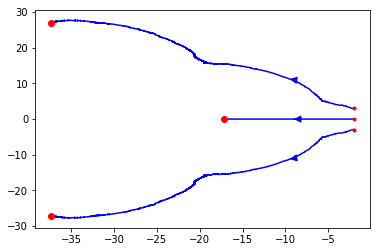

In [10]:
# another approach to plot
real_part = np.squeeze(real_vector(poles))
imag_part = np.squeeze(imag_vector(poles))
    
# Display a window with a plot of real, imag
line = plt.plot(real_part, imag_part, 'b-')
#plt.plot(real_part, imag_part, 'gx')
plt.plot(real_part[-1], imag_part[-1], 'ro')
plt.plot(real_part[0], imag_part[0], 'r.')

try:
    add_arrow(line[0], -9)
    add_arrow(line[1], -9)
    add_arrow(line[2], -9)
except:
    pass
##zeros
#real_part = np.squeeze(real_vector(zeros))
#imag_part = np.squeeze(imag_vector(zeros))
    
# Display a window with a plot of real, imag
#plt.plot(real_part, imag_part, 'g-')
#plt.plot(real_part, imag_part, 'g')
#plt.plot(real_part[-1], imag_part[-1], 'rx')
#plt.plot(real_part[0], imag_part[0], 'bx')

#plt.xlim(-30, 1)
#plt.ylim(-25, 25)
plt.show()

In [11]:
plt.rcParams['figure.figsize'] = [15, 7]
#import mpld3
#mpld3.enable_notebook()

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def every_nth(arr, n, T=1):
    return [T*np.array(range(0, len(arr))[::n]), arr[::n]]


Done steps 7854


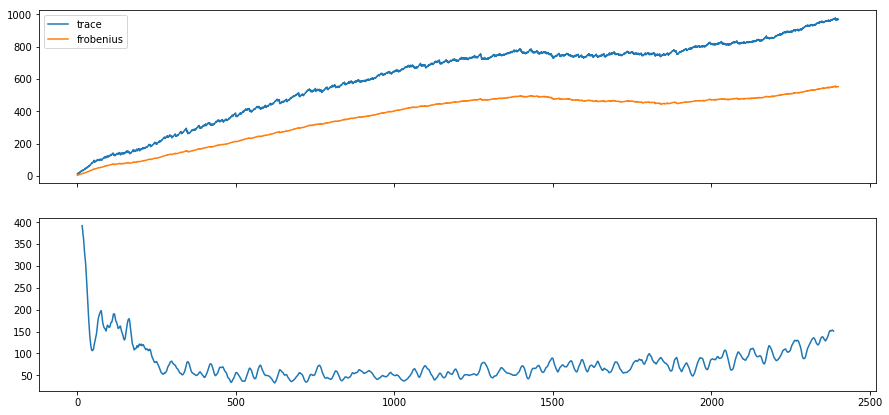

In [12]:
tt = np.arange(T, T_max, T)

ax1 = plt.subplot(2, 1, 1)

ax1.plot(t_ye, nor0, label="trace")
ax1.plot(t_ye, nor1, label="frobenius")
#ax1.plot(t_ye, nor2, label="inf norm")
#ax1.plot(t_ye, nor3, label="1 norm")
#ax1.plot(t_ye, nor4, label="2 norm")

ax1.legend()
#  H-inf Norm in mov-window
#  Entropy in mov-window
#  Highpass
#plt.show()

ax2 = plt.subplot(2, 1, 2, sharex=ax1)

df1 = pd.DataFrame(y_e, index=t_ye)
df2 = pd.DataFrame(y, index=tt).fillna(np.inf)
#print df2
df3 = pd.concat([df1, df2], axis=1).interpolate()

df_diff = df3.diff(axis=1).iloc[:,1]
#df_diff.plot()

#df_diff.abs().cumsum().plot()
#ax3 = plt.subplot(4, 1, 3, sharex=ax1)
df_diff.abs().rolling(window=30000, center=True, win_type="bartlett").sum().plot()
#plt.show()

#ax4 = plt.subplot(4, 1, 4, sharex=ax1)

#ax4.plot(tt, u, 'r', label="setp u")
#ax4.plot(tt, y, 'b', label="real y")
#ax4.plot(t_ye, y_e, 'y-', label="esti y")

#ax3.legend()
#plt.show()

print "Done steps", step_cnt

In [13]:
print nor0[-1]
print nor1[-1]

969.3487361490654
552.1864190409524


In [14]:
A_k = iekf.AA(*iekf.z_k.ravel())
B_k = iekf.BB(*iekf.z_k.ravel())
C_k = iekf.CC(*iekf.z_k.ravel())
D_k = iekf.DD(*iekf.z_k.ravel())

ss = pc.ss(A_k, B_k, C_k, D_k)

#print poles[-1]
print ss

A = [[-37.39391151  27.02086146   0.        ]
 [-27.02086146 -37.39391151   0.        ]
 [  0.           0.         -17.17463946]]

B = [[ 18.20013576]
 [-12.78088491]
 [ 30.41881231]]

C = [[-0.27025816  2.35103202  1.19583974]]

D = [[-0.00364341]]



In [15]:
print pc.dcgain(ss3)
print ss3.pole()
print ss3.zero()
print "----"
print pc.dcgain(ss)
print ss.pole()
print ss.zero()

[[1.0041837]]
[-111.24285968+106.12952188j -111.24285968-106.12952188j
 -140.47828097  +0.        j  -54.39316289  +0.        j
  -20.34039021  +0.        j]
[-1.95450403e+15  +0.       j  1.11242860e+02+106.1295219j
  1.11242860e+02-106.1295219j  1.40478281e+02  +0.       j]
----
[[1.00067242]]
[-37.39391151+27.02086146j -37.39391151-27.02086146j
 -17.17463946 +0.        j]
[ 51.57592181+223.01542234j  51.57592181-223.01542234j
 191.61671329  +0.        j]


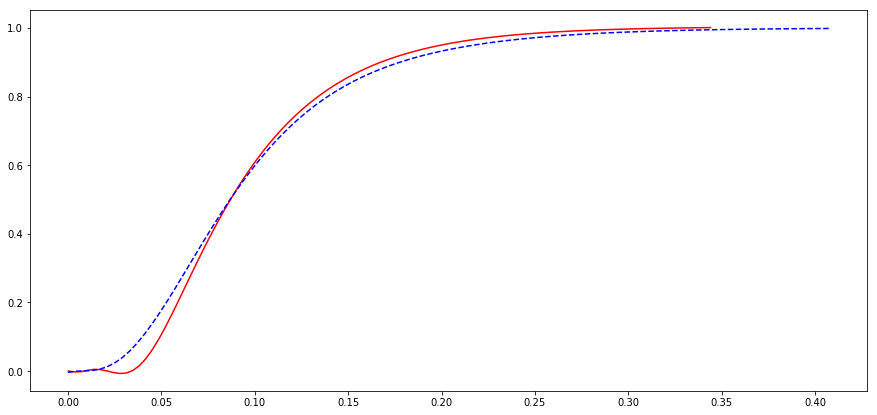

In [16]:
yout3, T3 = pc.step_response(ss3)
plt.plot(yout3, T3, 'r')
#plt.show()

yout4, T4 = pc.step_response(ss)
plt.plot(yout4, T4, 'b--')



plt.show()